# Test pynsitu.tseries.get_spectrum 
- test get_spectrum reaction to holes in time series, and the way it can interpolate it

In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, datetime
from matplotlib.colors import cnames

In [2]:
def get_spectrum(
    v,
    N,
    dt=None,
    N_fill_limit=24,
    method="periodogram",
    detrend=False,
    nan_ratio=0.1,
    **kwargs,
):
    """Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time
    and along the same time line.
    Parameters
    ----------
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
        N: int
            Length of the output
        dt: float, optional
            Time step
        N_fill_limit : int
            Limit length of Nan gap filled by interpolatation
        method: string
            Method that will be employed for spectral calculations.
            Default is 'periodogram'
        detrend: str or function or False, optional
            Turns detrending on or off. Default is False.
        nan_ratio : float between 0 and 1
            limit of nan value ratio tolerated in time series
            default is 0.1
    CAUTION : if v ndarray need to give dt
    See:
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    """

    if isinstance(v, np.ndarray):
        v = pd.Series(
            v
        )  # harmonising code (solving pb np.ndarray -> isnan(), pd.Series ->isna())

    nan_r = v.iloc[:N].isna().sum() / N

    if v is None:
        _v = pd.Series(np.random.randn(N), v.index[:N])

    # returned spectrum is nan array if to many nan holes
    elif (
        nan_r >= nan_ratio
    ):  # Avoids computing spectra where a large part of value come from interpolation
        warnings.warn(
            f"Nan values ratio {round(100 * nan_r)}% exceeds the {100*nan_ratio}% tolerated limit, replace spectrum by nan array",
            UserWarning,
        )
        _v = pd.Series(np.full(N, np.nan), v.index[:N])

    # fill little nan hole by interpolation
    elif N_fill_limit is not None:
        mask = v.isna()
        x = (
            mask.groupby((mask != mask.shift()).cumsum()).transform(
                lambda x: len(x) > N_fill_limit
            )
            * mask
        )  # True in holes bigger than N_fill_limit
        if x.any():
            warnings.warn(
                f"Hole(s) bigger than the tolerated length for interpolation {N_fill_limit}, replace spectrum by nan array",
                UserWarning,
            )
            _v = pd.Series(np.full(N, np.nan), v.index[:N])
        else:
            _v = v.interpolate(
                method="quadratic"
            )  # interpolate on hole smaller than N_fill_limit
            _v = _v.iloc[:N]

    else:
        _v = v.iloc[:N]

    if dt is None:
        dt = _v.reset_index()["index"].diff().mean()

    if detrend and not method == "periodogram":
        print("!!! Not implemented yet except for periodogram")
    if method == "periodogram":
        from scipy import signal

        dkwargs = {
            "window": "hann",
            "return_onesided": False,
            "detrend": detrend,
            "scaling": "density",
        }
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1 / dt, axis=0, **dkwargs)
    elif method == "mtspec":
        from mtspec import mtspec

        lE, f = mtspec(
            data=_v, delta=dt, time_bandwidth=4.0, number_of_tapers=6, quadratic=True
        )
    elif method == "mt":
        import nitime.algorithms as tsa

        dkwargs = {"NW": 2, "sides": "twosided", "adaptive": False, "jackknife": False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1 / dt, **dkwargs)
        f = fftfreq(len(lf)) * 24.0
        # print('Number of tapers = %d' %(nu[0]/2))
    return _v, pd.Series(E, index=f)

# Test too many holes

<AxesSubplot: >

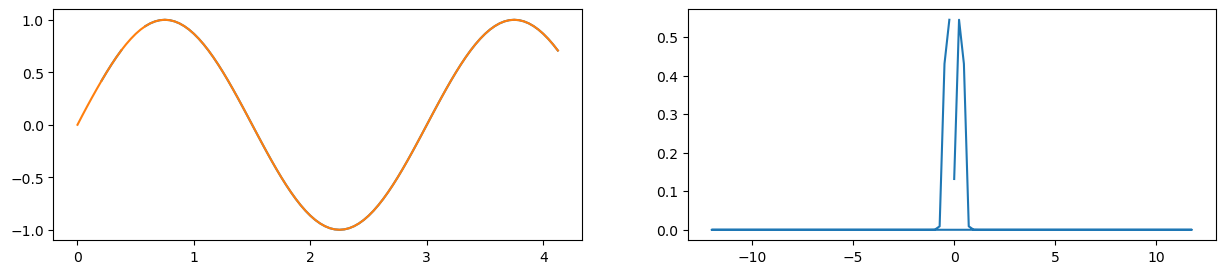

In [34]:
t = np.arange(0, 500, 1 / 24)
lu = pd.Series(np.sin(2 * np.pi * t / 3), t)
lv = pd.Series(np.sin(2 * np.pi * t / 3) + 3, t)
l = lu + 1j * lv

l.iloc[1:5] = np.nan
l.iloc[10:14] = np.nan

g = get_spectrum(l, 100)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
l.iloc[:100].plot(ax=axs[0])
g[0].plot(ax=axs[0])
g[1].plot(ax=axs[1])

/dev/shm/pbs.3772250.datarmor0/ipykernel_42606/3523119688.py:41: UserWarning: Nan values ratio 14% exceeds the 10.0% tolerated limit, replace spectrum by nan array
  warnings.warn(f"Nan values ratio {round(100 * nan_r)}% exceeds the {100*nan_ratio}% tolerated limit, replace spectrum by nan array", UserWarning)


<AxesSubplot: >

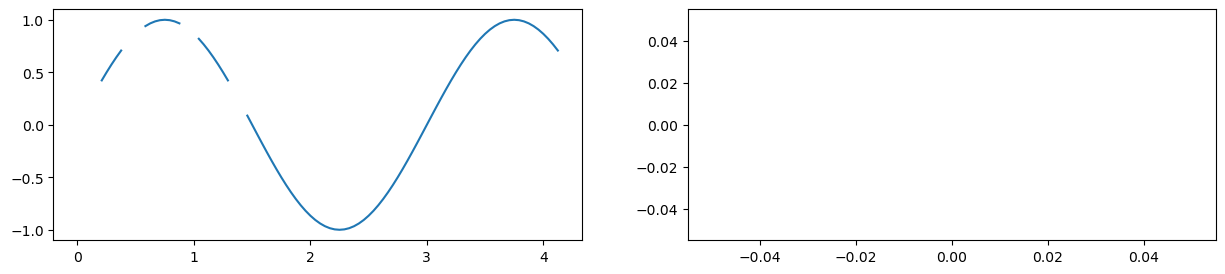

In [35]:
t = np.arange(0, 500, 1 / 24)
l = pd.Series(np.sin(2 * np.pi * t / 3), t)
l.iloc[1:5] = np.nan
l.iloc[10:14] = np.nan
l.iloc[22:25] = np.nan
l.iloc[32:35] = np.nan
g = get_spectrum(l, 100)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
l.iloc[:100].plot(ax=axs[0])
g[0].plot(ax=axs[0])
g[1].plot(ax=axs[1])

# Test little nan hole fill

<AxesSubplot: >

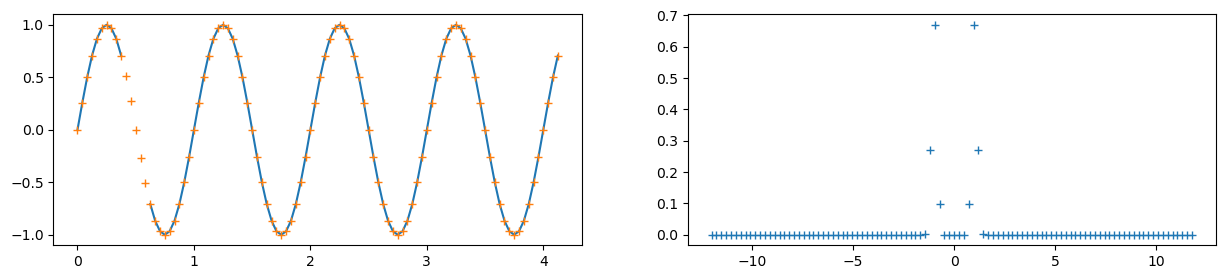

In [36]:
# little
t = np.arange(0, 500, 1 / 24)
l = pd.Series(np.sin(2 * np.pi * t), t)
l.iloc[10:15] = np.nan
g = get_spectrum(l, 100)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
l.iloc[:100].plot(ax=axs[0])
g[0].plot(ax=axs[0], ls="", marker="+")
g[1].plot(ax=axs[1], ls="", marker="+")

/dev/shm/pbs.3772250.datarmor0/ipykernel_42606/3523119688.py:49: UserWarning: Hole(s) bigger than the tolerated length for interpolation 24, replace spectrum by nan array
  warnings.warn(f"Hole(s) bigger than the tolerated length for interpolation {N_fill_limit}, replace spectrum by nan array", UserWarning)


<AxesSubplot: >

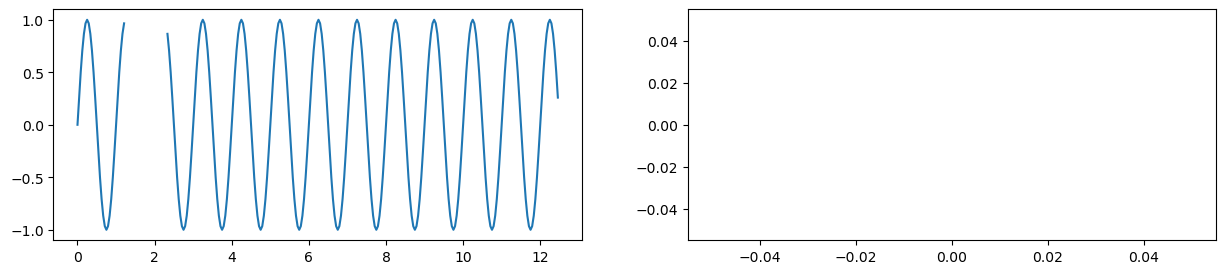

In [37]:
# too big
t = np.arange(0, 500, 1 / 24)
l = pd.Series(np.sin(2 * np.pi * t), t)
l.iloc[30:56] = np.nan
g = get_spectrum(l, 300)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
l.iloc[:300].plot(ax=axs[0])
g[0].plot(ax=axs[0], ls="", marker="+")
g[1].plot(ax=axs[1], ls="", marker="+")

# Test ndarray

/dev/shm/pbs.3772250.datarmor0/ipykernel_42606/3523119688.py:41: UserWarning: Nan values ratio 52% exceeds the 10.0% tolerated limit, replace spectrum by nan array
  warnings.warn(f"Nan values ratio {round(100 * nan_r)}% exceeds the {100*nan_ratio}% tolerated limit, replace spectrum by nan array", UserWarning)


<AxesSubplot: >

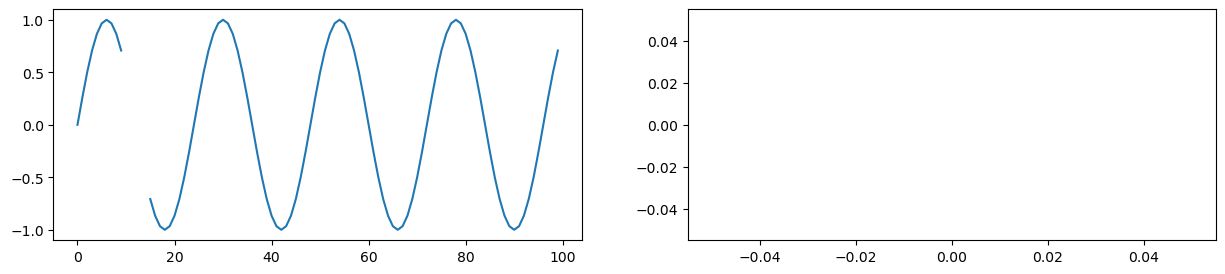

In [38]:
l = np.sin(2 * np.pi * t)
l[10:15] = np.nan
l[100:200] = np.nan
g = get_spectrum(l, 200)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(np.arange(100), l[:100])
g[0].plot(ax=axs[0])
g[1].plot(ax=axs[1])

<AxesSubplot: >

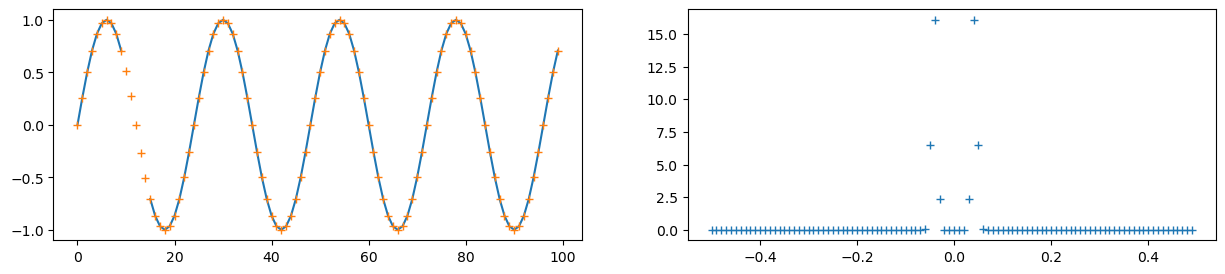

In [39]:
l = np.sin(2 * np.pi * t)
l[10:15] = np.nan
g = get_spectrum(l, 100, N_fill_limit=24)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(np.arange(100), l[:100])
g[0].plot(ax=axs[0], ls="", marker="+")
g[1].plot(ax=axs[1], ls="", marker="+")

/dev/shm/pbs.3772250.datarmor0/ipykernel_42606/3523119688.py:41: UserWarning: Nan values ratio 20% exceeds the 10.0% tolerated limit, replace spectrum by nan array
  warnings.warn(f"Nan values ratio {round(100 * nan_r)}% exceeds the {100*nan_ratio}% tolerated limit, replace spectrum by nan array", UserWarning)


<AxesSubplot: >

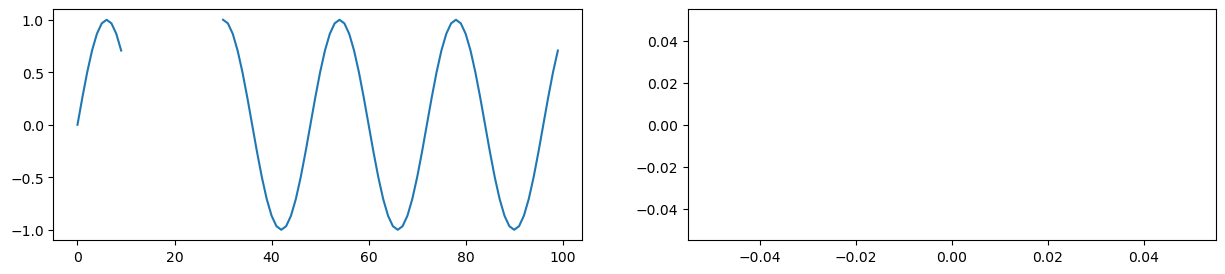

In [40]:
# too big
l = np.sin(2 * np.pi * t)
l[10:30] = np.nan
g = get_spectrum(l, 100, N_fill_limit=24)
fig, axs = plt.subplots(1, 2, figsize=(15, 3))
axs[0].plot(np.arange(100), l[:100])
g[0].plot(ax=axs[0], ls="", marker="+")
g[1].plot(ax=axs[1], ls="", marker="+")